In [1]:
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import cv2

from tqdm import tqdm
from scipy.special import kl_div
from scipy.stats import entropy
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, MaxPooling2D, Conv2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from tensorflow.keras.applications import InceptionV3

2023-10-21 15:11:27.878778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 15:11:28.562178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-21 15:11:29.912256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 15:11:29.976465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 15:11:29.976663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
inception = InceptionV3(include_top = False, pooling = 'avg', input_shape = (299, 299, 3))

In [5]:
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing_small.hdf5', 'r')
x_test = np.asarray(hf_test['image'][0 : ])

for i in range(len(x_test)): 
    x_test[i] = x_test[i] / np.amax(x_test[i])

In [ ]:
hf_val = h5py.File('/data/HSC/HSC_v6/step2A/64x64/5x64x64_validation_small.hdf5', 'r')
x_val = np.asarray(hf_val['image'][0 : ])

for i in range(len(x_val)): 
    x_val[i] = x_val[i] / np.amax(x_val[i])

In [40]:
hf_cvae = h5py.File('/data3/Billy/64x64_cvae_generated_13.hdf5', 'r')
x_cvae = np.asarray(hf_cvae['image'][0 : ])

for i in range(len(x_cvae)): 
    x_cvae[i] = x_cvae[i] / np.amax(x_cvae[i])

In [33]:
hf_diffusion = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/64x64/5x64x64_diffusion_generated.hdf5', 'r')
x_diffusion = np.asarray(hf_diffusion['image'][0 : ])

for i in range(len(x_diffusion)): 
    x_diffusion[i] = x_diffusion[i] / np.amax(x_diffusion[i])

In [4]:
hf_gan = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/64x64/5x64x64_gan_generated.hdf5', 'r')
x_gan = np.asarray(hf_gan['image'][0 : ])

for i in range(len(x_gan)): 
    x_gan[i] = x_gan[i] / np.amax(x_gan[i])

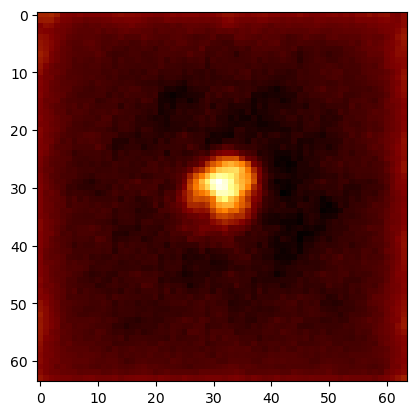

In [34]:
plt.imshow(x_diffusion[29][0], cmap = 'afmhot')

In [35]:
np.max(x_diffusion)

1.0

In [39]:
np.max(x_cvae)

184.6129

In [41]:
five_band_images_cvae = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_cvae[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_cvae[band][i] = stacked_image

100%|██████████| 2000/2000 [00:03<00:00, 517.28it/s]


In [6]:
five_band_images_gan = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_gan[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_gan[band][i] = stacked_image

100%|██████████| 2000/2000 [00:02<00:00, 826.86it/s]


In [36]:
five_band_images_diffusion = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_diffusion[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_diffusion[band][i] = stacked_image

100%|██████████| 2000/2000 [00:02<00:00, 877.97it/s]


In [14]:
five_band_images_test = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_test[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_test[band][i] = stacked_image

100%|██████████| 2000/2000 [00:02<00:00, 671.77it/s]


In [8]:
five_band_images_val = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_val[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_val[band][i] = stacked_image

100%|██████████| 2000/2000 [00:04<00:00, 468.94it/s]


In [7]:
def calculate_inception_score(images, inception_model):
    
    # Get predictions for the images
    preds = inception_model.predict(images)
    
    # For numerical stability, subtract the maximum value from predictions
    preds = preds - np.max(preds, axis=1, keepdims=True)
    
    # Compute the probabilities using softmax in a numerically stable way
    exp_preds = np.exp(preds)
    sum_exp_preds = np.sum(exp_preds, axis=1, keepdims=True)
    preds = exp_preds / sum_exp_preds
    
    # Add a small constant epsilon to avoid log(0)
    epsilon = 1e-10
    preds = np.clip(preds, epsilon, 1. - epsilon)
    
    # Compute the KL divergence for each image
    mean_preds = np.mean(preds, axis=0)
    kl_divergences = preds * (np.log(preds) - np.log(np.expand_dims(mean_preds, 0)))
    
    # Compute the mean KL divergence
    sum_kl_divergences = np.sum(kl_divergences, axis=1)
    avg_kl_divergence = np.mean(sum_kl_divergences)
    
    # Compute the inception score
    inception_score = np.exp(avg_kl_divergence)
    
    return inception_score

In [8]:
def calculate_inception_score_five_band(images, inception_model):
    
    # Get predictions for the images
    
    total_score = 0
    
    for i in range(0, 5):
    
        # Get predictions for the images
        preds = inception_model.predict(images[i])
    
        # For numerical stability, subtract the maximum value from predictions
        preds = preds - np.max(preds, axis = 1, keepdims = True)
    
        # Compute the probabilities using softmax in a numerically stable way
        exp_preds = np.exp(preds)
        sum_exp_preds = np.sum(exp_preds, axis = 1, keepdims = True)
        preds = exp_preds / sum_exp_preds
    
        # Add a small constant epsilon to avoid log(0)
        epsilon = 1e-10
        preds = np.clip(preds, epsilon, 1. - epsilon)
    
        # Compute the KL divergence for each image
        mean_preds = np.mean(preds, axis = 0)
        kl_divergences = preds * (np.log(preds) - np.log(np.expand_dims(mean_preds, 0)))
    
        # Compute the mean KL divergence
        sum_kl_divergences = np.sum(kl_divergences, axis = 1)
        avg_kl_divergence = np.mean(sum_kl_divergences)
    
        # Compute the inception score
        inception_score = np.exp(avg_kl_divergence)
        
        print(inception_score)
        
        total_score += inception_score / 5
    
    return total_score

In [11]:
calculate_inception_score_five_band(five_band_images_test, inception)

2023-10-20 10:24:30.296873: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2023-10-20 10:24:32.824582: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2023-10-20 10:24:36.305023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-20 10:24:37.266082: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-20 10:24:37.504310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 7s 35ms/step
1.1738338


2023-10-20 10:24:47.042039: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2023-10-20 10:24:49.328927: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.


63/63 [==============================] - 2s 25ms/step
1.5232527


2023-10-20 10:25:00.380745: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.


63/63 [==============================] - 2s 25ms/step
1.8744447
63/63 [==============================] - 2s 25ms/step
1.9732214
63/63 [==============================] - 2s 25ms/step
2.0629318


1.721536898612976

In [12]:
calculate_inception_score_five_band(five_band_images_val, inception)

63/63 [==============================] - 2s 25ms/step
1.1922272
63/63 [==============================] - 2s 25ms/step
1.5083381
63/63 [==============================] - 2s 25ms/step
1.8544817
63/63 [==============================] - 2s 25ms/step
1.9728076
63/63 [==============================] - 2s 25ms/step
2.0718918


1.7199492931365967

In [8]:
calculate_inception_score_five_band(five_band_images_cvae, inception)

2023-10-20 10:32:30.350871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-20 10:32:30.804840: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-20 10:32:31.005809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 5s 34ms/step
1.2063286
63/63 [==============================] - 2s 25ms/step
1.3602604
63/63 [==============================] - 2s 25ms/step
1.6662036
63/63 [==============================] - 2s 25ms/step
1.7182112
63/63 [==============================] - 2s 25ms/step
1.7817289


1.546546530723572

In [14]:
calculate_inception_score_five_band(five_band_images_diffusion, inception)

63/63 [==============================] - 2s 25ms/step
1.0
63/63 [==============================] - 2s 25ms/step
1.0
63/63 [==============================] - 2s 25ms/step
3.471015
63/63 [==============================] - 2s 25ms/step
1.9789748
63/63 [==============================] - 2s 25ms/step
1.884097


1.8668173551559448

In [9]:
calculate_inception_score_five_band(five_band_images_gan, inception)

2023-10-21 15:13:02.628363: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2023-10-21 15:13:03.802255: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2023-10-21 15:13:06.623540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-21 15:13:07.594505: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-21 15:13:07.962000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 8s 55ms/step
1.004633


2023-10-21 15:13:21.049143: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2023-10-21 15:13:22.157326: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.


63/63 [==============================] - 2s 33ms/step
1.0046881


2023-10-21 15:13:31.353894: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.


63/63 [==============================] - 2s 33ms/step
1.0026469
63/63 [==============================] - 2s 33ms/step
1.0032113
63/63 [==============================] - 2s 33ms/step
1.0026242


1.00356068611145

In [10]:
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    
    # row_sums = np.sum(real_features, axis = 1)[:, np.newaxis]  # Sum along each row and keep dimensions with np.newaxis
    # real_features = real_features / row_sums
    
    # row_sums = np.sum(generated_features, axis = 1)[:, np.newaxis]  # Sum along each row and keep dimensions with np.newaxis
    # generated_features = generated_features / row_sums
    
    mu1, sigma1 = real_features.mean(axis = 0), np.cov(real_features, rowvar = False)
    mu2, sigma2 = generated_features.mean(axis = 0), np.cov(generated_features, rowvar = False)
    
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [12]:
def calculate_fid(real_features, generated_features):
    
    # Debugging info
    # print("Real features shape:", real_features.shape)
    # print("Generated features shape:", generated_features.shape)
    
    # print("Real features mean:", np.mean(real_features))
    # print("Generated features mean:", np.mean(generated_features))
    
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    
    # More debugging info
    # print("Sigma1:", sigma1)
    # print("Sigma2:", sigma2)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [42]:
test_features = inception.predict(five_band_images_test[0])
cvae_features = inception.predict(five_band_images_cvae[0])
fid_score_cvae = calculate_fid(test_features, cvae_features)
print(fid_score_cvae)

63/63 [==============================] - 2s 26ms/step
Real features shape: (2000, 2048)
Generated features shape: (2000, 2048)
Real features mean: 0.2560726
Generated features mean: 0.22202638
Sigma1: [[ 1.64063192e-01 -1.38221482e-02  5.59571111e-03 ...  1.17116872e-01
   1.39992090e-01 -2.17738575e-03]
 [-1.38221482e-02  7.14885081e-03  4.24374187e-05 ... -1.05649026e-02
  -1.22622204e-02  2.06145278e-03]
 [ 5.59571111e-03  4.24374187e-05  1.50279823e-02 ... -7.76723150e-03
  -8.19561830e-04  2.49716782e-03]
 ...
 [ 1.17116872e-01 -1.05649026e-02 -7.76723150e-03 ...  1.83857692e-01
   1.17411618e-01 -9.58997478e-03]
 [ 1.39992090e-01 -1.22622204e-02 -8.19561830e-04 ...  1.17411618e-01
   1.60998077e-01  1.66623792e-03]
 [-2.17738575e-03  2.06145278e-03  2.49716782e-03 ... -9.58997478e-03
   1.66623792e-03  1.83470596e-02]]
Sigma2: [[ 0.04156686  0.0010412  -0.00610675 ... -0.02073397  0.02033764
   0.00577331]
 [ 0.0010412   0.00049821 -0.00030832 ... -0.00134407 -0.0004976
   0.0005

In [16]:
test_features = inception.predict(five_band_images_test[0])
val_features = inception.predict(five_band_images_val[0])
fid_score_val = calculate_fid(test_features, val_features)
print(fid_score_val)

63/63 [==============================] - 2s 25ms/step
11.009589802463598


In [37]:
test_features = inception.predict(five_band_images_test[0])
diffusion_features = inception.predict(five_band_images_diffusion[0])
fid_score_diffusion = calculate_fid(test_features, diffusion_features)
print(fid_score_diffusion)

63/63 [==============================] - 3s 40ms/step
Real features shape: (2000, 2048)
Generated features shape: (2000, 2048)
Real features mean: 0.2560726
Generated features mean: 0.23123448
Sigma1: [[ 1.64063192e-01 -1.38221482e-02  5.59571111e-03 ...  1.17116872e-01
   1.39992090e-01 -2.17738575e-03]
 [-1.38221482e-02  7.14885081e-03  4.24374187e-05 ... -1.05649026e-02
  -1.22622204e-02  2.06145278e-03]
 [ 5.59571111e-03  4.24374187e-05  1.50279823e-02 ... -7.76723150e-03
  -8.19561830e-04  2.49716782e-03]
 ...
 [ 1.17116872e-01 -1.05649026e-02 -7.76723150e-03 ...  1.83857692e-01
   1.17411618e-01 -9.58997478e-03]
 [ 1.39992090e-01 -1.22622204e-02 -8.19561830e-04 ...  1.17411618e-01
   1.60998077e-01  1.66623792e-03]
 [-2.17738575e-03  2.06145278e-03  2.49716782e-03 ... -9.58997478e-03
   1.66623792e-03  1.83470596e-02]]
Sigma2: [[ 0.02481096  0.00209207  0.01005373 ...  0.02895244  0.01003474
   0.01711846]
 [ 0.00209207  0.00181755  0.00047814 ...  0.00369496 -0.00015507
   0.001

In [15]:
test_features = inception.predict(five_band_images_test[0])
gan_features = inception.predict(five_band_images_gan[0])
fid_score_gan = calculate_fid(test_features, gan_features)
print(fid_score_gan)

63/63 [==============================] - 2s 31ms/step
215.92554625962978


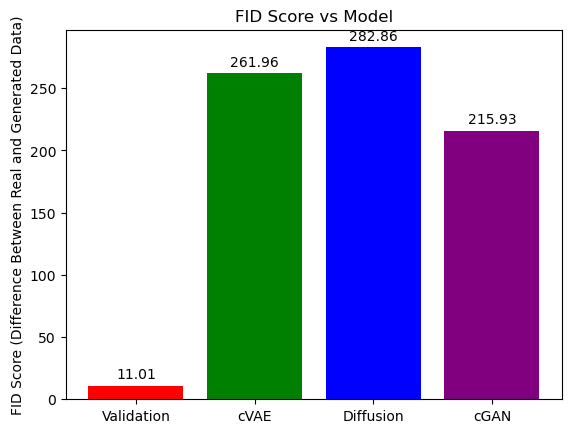

In [18]:
labels = ['Validation', 'cVAE', 'Diffusion', 'cGAN']
values = [11.01, 261.96, 282.86, 215.93]

# Create figure and axes
fig, ax = plt.subplots()

# Generate the bars
bars = plt.bar(labels, values, color=['red', 'green', 'blue', 'purple'])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('FID Score (Difference Between Real and Generated Data)')
ax.set_title('FID Score vs Model')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Label the bars with their values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

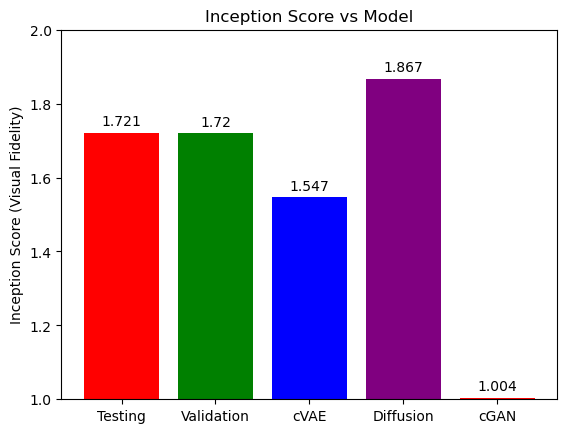

In [21]:
labels = ['Testing', 'Validation', 'cVAE', 'Diffusion', 'cGAN']
values = [1.721, 1.72, 1.547, 1.867, 1.004]

# Create figure and axes
fig, ax = plt.subplots()

# Generate the bars
bars = plt.bar(labels, values, color=['red', 'green', 'blue', 'purple'])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Inception Score (Visual Fidelity)')
ax.set_title('Inception Score vs Model')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Label the bars with their values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(1, 2)    

plt.show()

In [ ]:
# END